**Instructions:**

- For questions that require coding, you need to write the relevant code and display its output. Your output should either be the direct answer to the question or clearly display the answer in it.
- For questions that require a written answer (sometimes along with the code), you need to put your answer in a Markdown cell. Writing the answer as a comment or as a print line is not acceptable.
- You need to render this file as HTML using Quarto and submit the HTML file. **Please note that this is a requirement and not optional.** A submission cannot be graded until it is properly rendered.

Import all the libraries and tools you need below.

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC, SVR
from sklearn.decomposition import PCA

## 1) Preprocessing (5 points)

### a)

Read the data from **tumor_classification.csv**. Each observation represents numeric measurements taken from the biopsy image of a patient. The `diagnosis` variable represents if the tumor is benign (`B`) or malignant (`M`) and it is the response/target variable. All the other variables, except for `id`, are the predictors.

Separate the response and the predictors.

**(1.5 points)**

In [65]:
# read data
tumor_classification = pd.read_csv('tumor_classification.csv')

# Separate data to response and predictors
X = tumor_classification.drop(['id', 'diagnosis'], axis = 1)
y = tumor_classification['diagnosis']



### b)

Save the predictor names to a new variable. It will be used later in this assignment. **(1.5 points)**

In [66]:
# Save the array of predictor names
predictor_name = np.array(X.columns)

### c)

Scale the predictors. Note that this is a bit different than what you have done in the previous assignments. You are scaling the full dataset before splitting it into training and test sets. **(2 points)**

In [67]:
# Scale the predictors
scale = StandardScaler()
scale.fit(X)
X_scaled = scale.transform(X)

## 2) Principal Component Analysis (PCA) (50 points)

Answer the following questions by creating different [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) objects with the **scaled data**.

### a)

If the data is reduced to **five** dimensions, what percentage of its variance is kept? **(10 points)**

In [87]:
# Create a pca
pca = PCA()

# fit pca
pca.fit(X_scaled)

# Check the explanied variance ratio
variance = pca.explained_variance_ratio_

# Get the sum of top 5 componenets
variance_top5 = sum(variance[0:5])
variance_top5

0.8473427431680723

The 84.73 % $\approx$ 85 % of the variance is kept.

### b)

How many dimensions are necessary to keep 99% of the variance in the data? **(10 points)**

In [93]:
# Create a function returning number of dimensions
def lowest_dimesion_need(variance, var_kept):
    sum_var = 0
    i = 0
    while sum_var < var_kept:
        sum_var += variance[i]
        i += 1
    return i

lowest_dimesion_need(variance, var_kept= 0.99)


17

We need 17 dimensions to keep at least 99 % of the variance.

### c)

To visualize the dimensionality-variance trade-off better, create a bar plot that shows the proportion of total variance each Principal Component (PC) holds. **(15 points)**

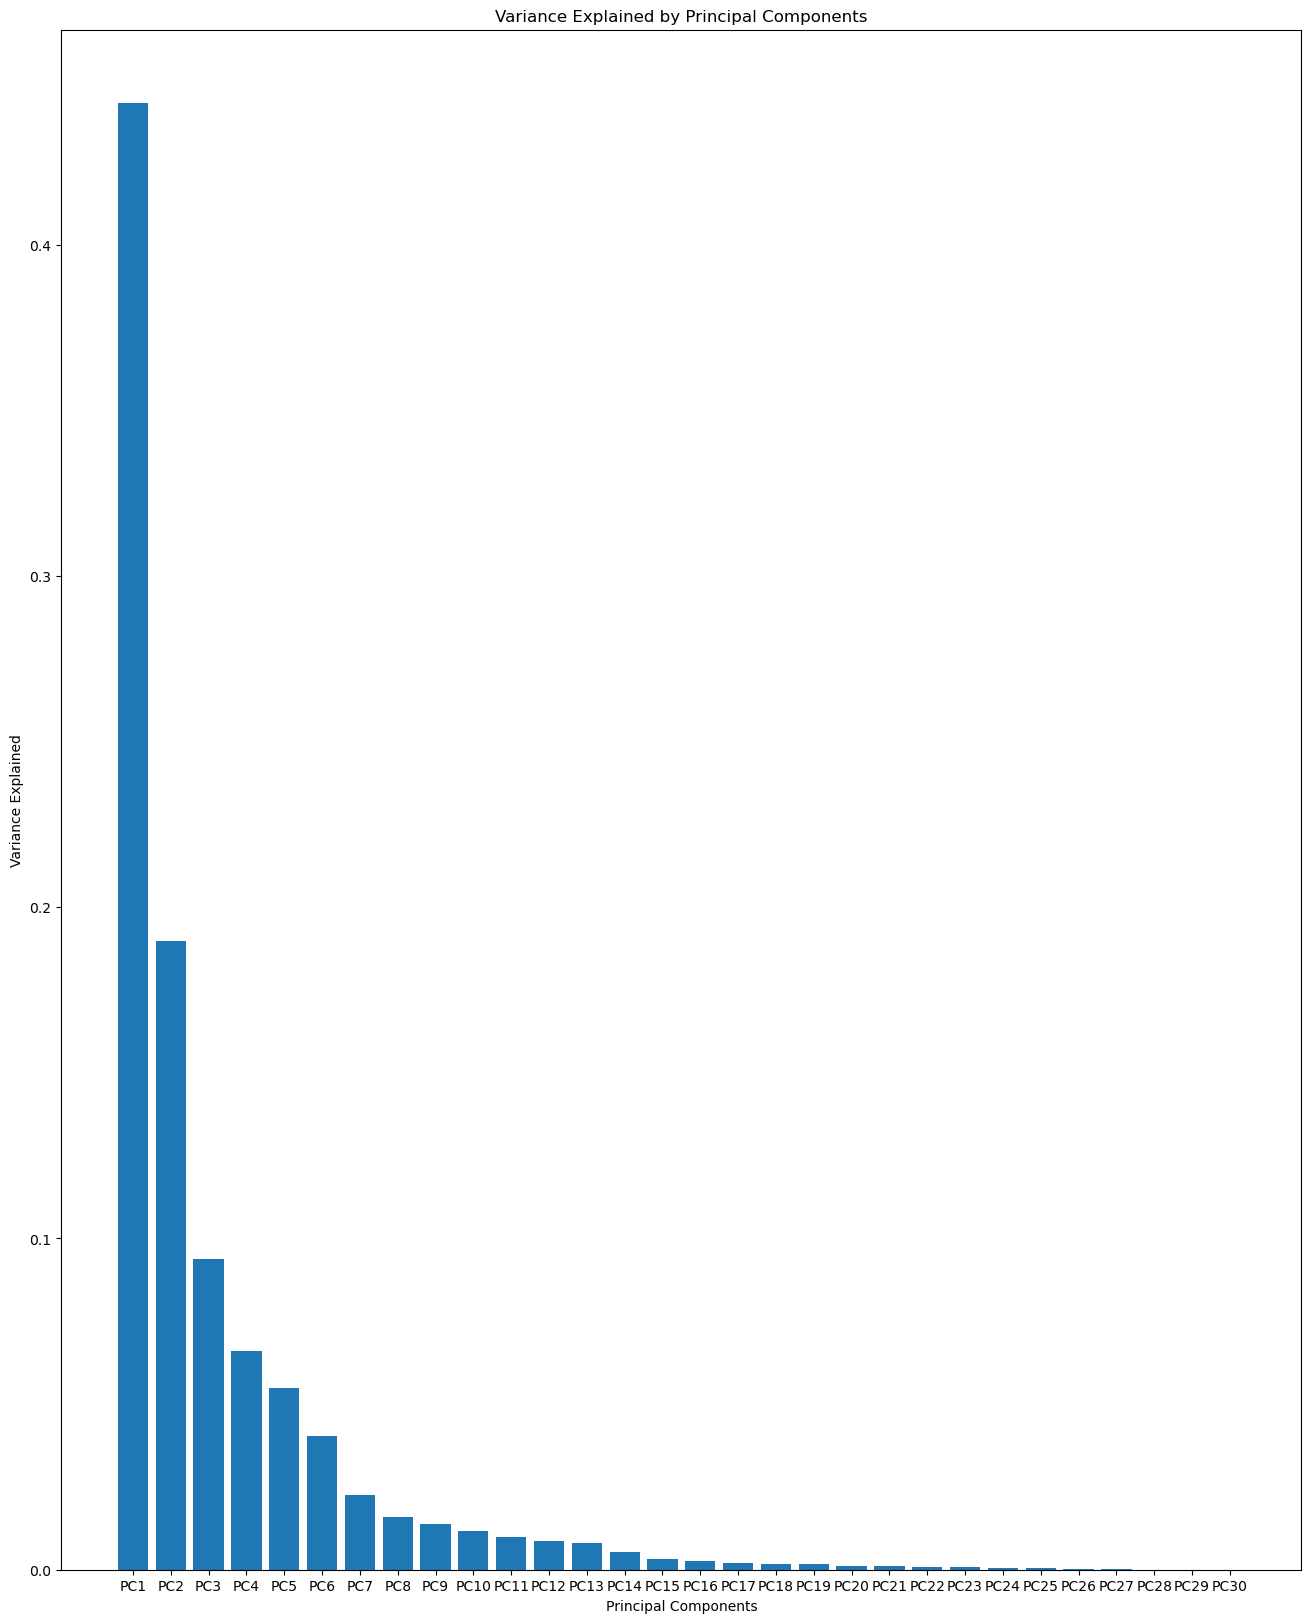

In [89]:
# Create a bar plot
plt.figure(figsize= (16, 20))
plt.bar([f'PC{i + 1}' for i in range(len(variance))], variance)
plt.xlabel("Principal Components")
plt.ylabel("Variance Explained")
plt.title("Variance Explained by Principal Components")
plt.show()


### d)

For the first three PCs, find and print the names of the three predictors with the most contribution. (You need to print nine predictor names in total.) Do you see a pattern in the names? Are there any predictors that appear (in the top three) for more than one PC? Why or why not? **(15 points)**

**Hint:** [argsort](https://numpy.org/doc/2.1/reference/generated/numpy.argsort.html) function can be helpful.

In [103]:
# Print the most dominant features of PC
# Get the last three index of argsort 
for i in range(3):
    print(f'Most Contributing Predictors for PC{i + 1}:{predictor_name[np.argsort(pca.components_[i])[-3:]]}')


Most Contributing Predictors for PC1:['concave points_worst' 'concavity_mean' 'concave points_mean']
Most Contributing Predictors for PC2:['fractal_dimension_worst' 'fractal_dimension_se' 'fractal_dimension_mean']
Most Contributing Predictors for PC3:['symmetry_se' 'smoothness_se' 'texture_se']


## 3) PCA with Logistic Regression (45 points)

### a)

Split the data into **stratified** training and test sets with a 80%-20% ratio and `random_state=12`. Keep in mind that the input predictors should already be scaled. **(2 points)**

In [91]:
# Split the data into 80-20
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state= 12, stratify= y, test_size= 0.20)

### b)

Create a Logistic Regression model **without any penalty** and with `random_state=12`.

This dataset is easily classifiable, so leave all the other inputs and the decision threshold as default. Train the model and print the test accuracy and the test confusion matrix. You will need to compare the results in this part with the following parts.

**(5 points)**

In [94]:
# Create a logistic regression model
log_reg = LogisticRegression(random_state= 12, penalty= None)

# Train the model
log_reg.fit(X_train, y_train)

# Predict with the model
y_pred = log_reg.predict(X_test)

# Get the confusion matrix
print(f'accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Confusion Matrix: {confusion_matrix(y_test, y_pred)}')

accuracy: 0.956140350877193
Confusion Matrix: [[67  5]
 [ 0 42]]


### c)

Repeat Parts a and b four times (with the same `random_state`): Before the train-test split, reduce the dimensionality of the data with **99%, 97%, 95% and 90%** of the variance kept, respectively. Afterwards, take the same steps as in Parts a and b.

Print the test accuracy and the test confusion matrix for each repetition.

**Note:** In this assignment, the test results are compared to demonstrate how PCA affects classification, so it is used more as a validation set. In Homework Assignment 3, you will tune both the PCA object and a classifier together with cross-validation.

**(30 points)**

In [95]:
# Use the loop to execute this operation 4 times
variance_kept = [0.99, 0.97, 0.95, 0.90]

for var_kept in variance_kept:
    dim = lowest_dimesion_need(variance, var_kept)
    # Develop pca
    pca = PCA(n_components = dim)
    # get X_pca from pca
    X_pca = pca.fit_transform(X_scaled)
    # Create a logistic regression model
    log_reg = LogisticRegression(random_state= 12, penalty= None)

    # Split the data into 80-20
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state= 12, stratify= y, test_size= 0.20)

    # Train the model
    log_reg.fit(X_train, y_train)

    # Predict with the model
    y_pred = log_reg.predict(X_test)

    # Get the confusion matrix
    print(f'accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Confusion Matrix: {confusion_matrix(y_test, y_pred)}')


accuracy: 0.9649122807017544
Confusion Matrix: [[69  3]
 [ 1 41]]
accuracy: 0.9912280701754386
Confusion Matrix: [[72  0]
 [ 1 41]]
accuracy: 0.9912280701754386
Confusion Matrix: [[72  0]
 [ 1 41]]
accuracy: 0.956140350877193
Confusion Matrix: [[69  3]
 [ 2 40]]


### d)

How do the test results change as the variance kept in the data decreases from 99% to 90%? Which percentage(s) return the best results? Explain the reasons for the results you see with the dimensionality-variance trade-off. **(8 points)**

The test result shows the increase of accuracy when we firstly decreases the amount of variance kept and then, at a certain reduction of variance, the accuracy starts to decrease. According to dimensionality-variance trade-off, the better performance of the model upon the testing dataset is due to the decreasing noises and less overfitting resulted from dimensionality eduction. However, at the certain level of dimensionality reduction, the important patterns between predictors and the response is removed and then the model performs worse.